In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pandas as pd
from scipy.integrate import simps
from scipy.stats import linregress


This is irrelevant at the moment, but just in case, but I have added filepaths to data_folder and loc_data_sipm in the same style as Todor. 

In [3]:
DATA_FOLDER = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/"
LOC_DATA_SIPM = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/"

Now, I will do the task Miguel wanted me to do. I will compute the Time over Threshold(ToT) for a given threshold. Find the mean and standard deviation of said ToT. And plot ToT against voltage. (MAYBE NOT ANYMORE, I DID SOMETHING ELSE BELOW)

In [4]:
def read_data(filename, seg_len, zero=True):
    filepath = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)

    
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]

    np.nan_to_num(waveforms[:,:,2], copy=False, nan=0)

    if zero==True:
        for waveform in waveforms:
            waveform[:,2] += np.abs(np.min(waveform[:,2]))
            plt.plot(waveform[:, 2])
    
    else: 
        for waveform in waveforms:
            plt.plot(waveform[:, 2])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveforms")
    plt.show()

    for waveform in waveforms:
        plt.plot(waveform[:, 1])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Trigger Signals")
    plt.show()

    return waveforms, n_segs


# def make_background_plot():
#     data = np.genfromtxt(DATA_FOLDER + "areas_sipm-411_bkg_57V.csv", delimiter=',')
#     data_range = np.max(data) - np.min(data)
#     bin_size = 2.7e-12
#     bins = int(data_range / bin_size)
#     plt.hist(data * 10**9, bins)
#     plt.xlabel("Charge [nV.s]", fontsize=15)
#     plt.ylabel("Frequency [{0:3.1f} counts / (nV.ms)]".format(bin_size* 10**12), fontsize=15)
#     plt.tick_params('both', labelsize=13)
#     plt.tight_layout()
#     plt.savefig(PLOTS_FOLDER + "background_sipm_411.png", dpi=600)
#     plt.show()

In [5]:
def find_roi(waveforms, n_segs, peak_start=0, turnover_start=0, turnover_end=0):

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2]))

    waveforms_sum = np.sum(waveforms, axis=0)
    savgol_filtered = savgol_filter(waveforms_sum[:, 2], 61, 9)
    savgol_filtered_deriv = savgol_filter(waveforms_sum[:, 2], 61, 9, deriv=1)

    avg = (waveforms_sum[:, 2] - np.mean(waveforms_sum[:, 2][0:500])) / n_segs
    avg_trig = waveforms_sum[:, 1] / n_segs

    turnover_point = np.argmin(savgol_filtered[turnover_start:turnover_end]) + turnover_start
    peak = np.argmax(savgol_filtered[peak_start:]) + peak_start

    plt.plot(waveforms_sum[:, 2], label="Summed Waveforms")
    plt.plot(savgol_filtered, label="Savitzky-Golay Filtered")
    plt.plot(savgol_filtered_deriv, label="Savitzky-Golay Filtered Derivative")
    plt.plot(turnover_point, savgol_filtered[turnover_point], 'ro', label="Turnover Point")
    plt.plot(peak, savgol_filtered[peak], 'bo', label="Peak")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Summed Waveforms")
    plt.legend()
    plt.show()

    return turnover_point, peak, avg, avg_trig

In [6]:
def integrate(waveforms, n_segs, start, peak, plot=False, title="add title"):
    areas = []

    for i in range(n_segs):
        x_data = waveforms[i, :, 0]
        y_data = waveforms[i, :, 2] - np.mean(waveforms[i, :, 2][0:500])

        roi = peak-start

        end = np.argmin(np.abs(y_data[peak:int(peak+4*roi)] - y_data[peak]/10)) + peak

        area = 0
        for j in range(int(end-start)):
            if y_data[j+start] + y_data[j+start+1] > 0:
                area += (x_data[j+start+1] - x_data[j+start]) * (y_data[j+start] + y_data[j+start+1]) / 2
            else: area +=0
        
        areas.append(area)

        if plot == True:
            plt.plot(x_data, y_data, '.', label="Noisy Data")
            plt.plot(x_data[start], y_data[start], 'ro', label="Start")
            plt.plot(x_data[peak], y_data[peak], 'bo', label="Peak")
            plt.plot(x_data[end], y_data[end], 'ko', label="End")
            plt.legend()
            plt.show()
    
    mean = np.mean(areas)
    std_dev = np.std(areas)

    plt.hist(areas, bins=20, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Charge [Vs]")
    plt.ylabel("Frequency")
    plt.annotate(f"Mean: {mean:.2e}\nStd. Dev: {std_dev:.2e}", xy=(0.02, 0.9), xycoords='axes fraction')
    plt.show()

    return areas, mean, std_dev

In [7]:
def integrate_single_waveform(file_path, start_offset=50, plot=False, title="Integrated Charge"):
    """
    Load waveform data, clean it, dynamically determine start, peak, and end points,
    and compute the integrated charge.

    Args:
        file_path (str): Path to the waveform CSV file.
        start_offset (int): Number of points before the peak to define the start.
        plot (bool): Whether to plot the waveform and integration region.
        title (str): Title for the plot.

    Returns:
        float: Integrated charge (area under the curve).
    """
    # Load data
    data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])
    x_data = pd.to_numeric(data["Time (s)"], errors="coerce").values
    y_data = pd.to_numeric(data["SiPM Signal (V)"], errors="coerce").values

    # Remove invalid (NaN) values
    valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
    x_data_clean = x_data[valid_indices]
    y_data_clean = y_data[valid_indices]

    # Subtract baseline noise using the first 500 points
    baseline = np.mean(y_data_clean[:500])
    y_data_cleaned = y_data_clean - baseline

    # Dynamically determine peak, start, and end indices
    peak_index = np.argmax(y_data_cleaned)  # Peak is where the signal is maximum
    start_index = max(0, peak_index - start_offset)  # Start 50 points before the peak
    end_index = np.argmin(np.abs(y_data_cleaned[peak_index:] - y_data_cleaned[peak_index] / 10)) + peak_index

    # Integrate the signal using the trapezoidal rule
    integration_range = slice(start_index, end_index + 1)
    area = np.trapz(y_data_cleaned[integration_range], x_data_clean[integration_range])

    # Plot the waveform and integration region if requested
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(x_data_clean, y_data_cleaned, label="Cleaned Waveform", color="orange")
        plt.plot(x_data_clean[start_index], y_data_cleaned[start_index], 'ro', label="Start")
        plt.plot(x_data_clean[peak_index], y_data_cleaned[peak_index], 'bo', label="Peak")
        plt.plot(x_data_clean[end_index], y_data_cleaned[end_index], 'ko', label="End")
        plt.title(title)
        plt.xlabel("Time [s]")
        plt.ylabel("Signal [V]")
        plt.legend()
        plt.grid()
        plt.show()

    return area


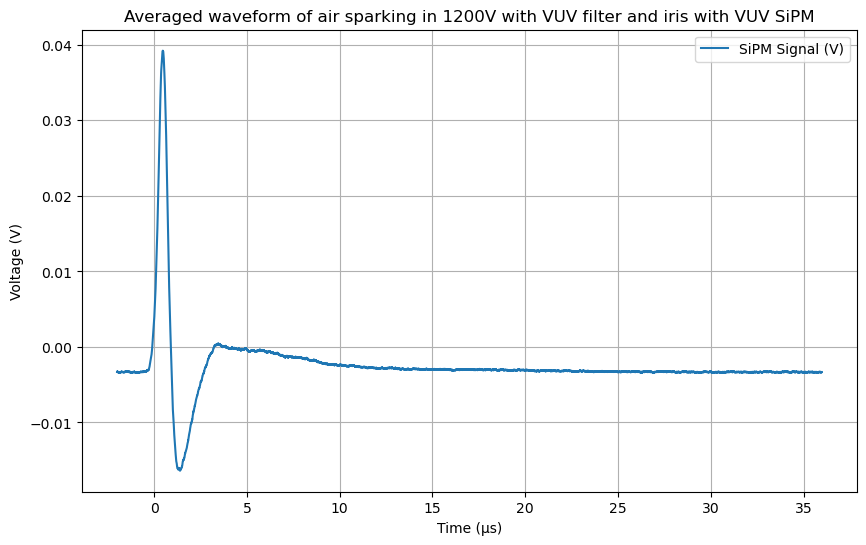

In [8]:
file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_air_VUVlastday run 2 (averaged waveform).csv"
# Clean the data
# Skip the first row with units and rename columns for clarity
cleaned_data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])

# Convert columns to numeric values, stripping any formatting issues
cleaned_data["Time (s)"] = pd.to_numeric(cleaned_data["Time (s)"], errors="coerce") * 1e6

# Convert columns to numeric values, ensuring all are treated as strings first
# cleaned_data["Trigger Signal (V)"] = pd.to_numeric(
#     cleaned_data["Trigger Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce"
# )
cleaned_data["SiPM Signal (V)"] = pd.to_numeric(
    cleaned_data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce"
)

# Define the plotting function
def plot_waveform(data, x_column, y_columns, title="Waveform", xlabel="Time (µs)", ylabel="Voltage (V)"):
    plt.figure(figsize=(10, 6))
    for y_column in y_columns:
        plt.plot(data[x_column], data[y_column], label=y_column)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

# Plot the waveform using the function
plot_waveform(cleaned_data, "Time (s)", ["SiPM Signal (V)"], title="Averaged waveform of air sparking in 1200V with VUV filter and iris with VUV SiPM")



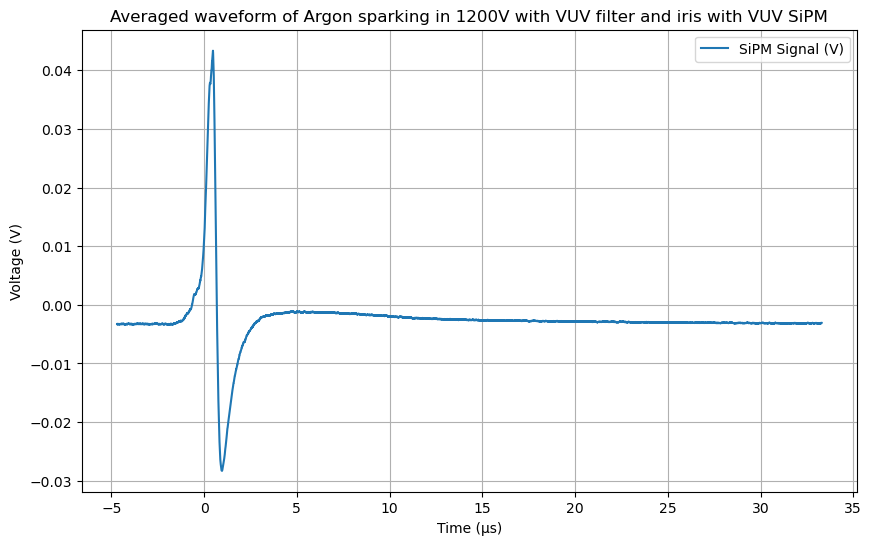

In [9]:
file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_Ar_VUVlastday (averaged waveform).csv"
# Clean the data
# Skip the first row with units and rename columns for clarity
cleaned_data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])

# Convert columns to numeric values, stripping any formatting issues
cleaned_data["Time (s)"] = pd.to_numeric(cleaned_data["Time (s)"], errors="coerce") * 1e6

# Convert columns to numeric values, ensuring all are treated as strings first
# cleaned_data["Trigger Signal (V)"] = pd.to_numeric(
#     cleaned_data["Trigger Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce"
# )
cleaned_data["SiPM Signal (V)"] = pd.to_numeric(
    cleaned_data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce"
)

# Define the plotting function
def plot_waveform(data, x_column, y_columns, title="Waveform", xlabel="Time (µs)", ylabel="Voltage (V)"):
    plt.figure(figsize=(10, 6))
    for y_column in y_columns:
        plt.plot(data[x_column], data[y_column], label=y_column)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

# Plot the waveform using the function
plot_waveform(cleaned_data, "Time (s)", ["SiPM Signal (V)"], title="Averaged waveform of Argon sparking in 1200V with VUV filter and iris with VUV SiPM")

The story behind why we skipped over 1000V is because the data was overwritten and we didn't realise it when we were taking measurements from 900V till 1200V (MENTION THIS IN THE REPORT and INTERVIREW)

# 1. Air nothing Vs air blind (we proved that we discarded electronic crosstalk)

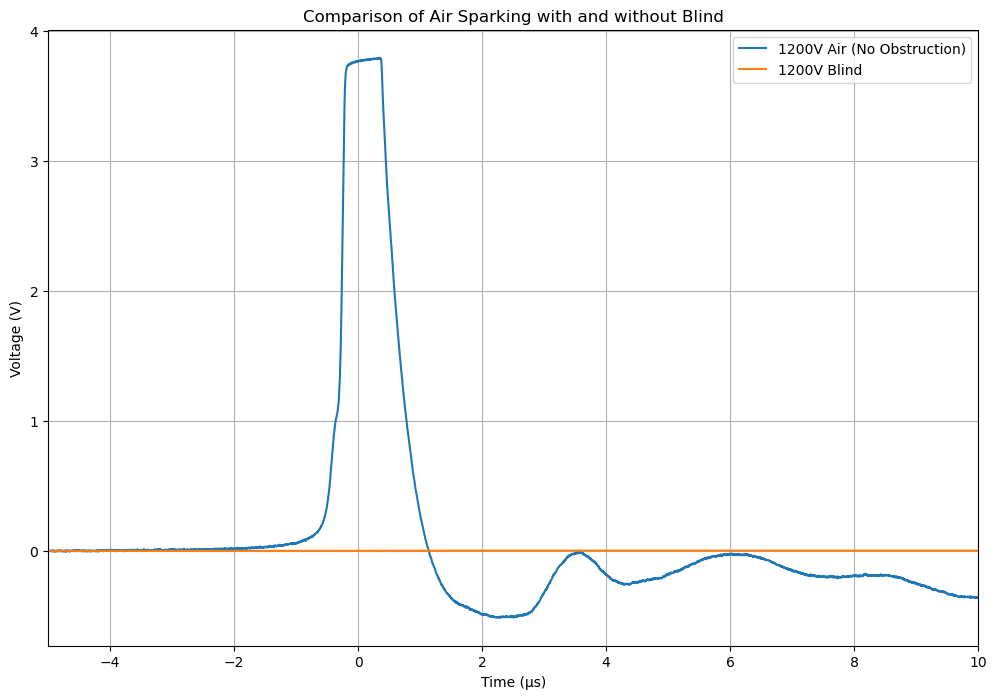

In [10]:
# File paths for uploaded CSV files
file_paths = [
    # 'C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_Ar_VUVlastday (averaged waveform).csv',
    # 'C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/900V_air_VUVlastday (averaged waveform).csv',
    # 'C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1000V_air_VUVlastday (averaged waveform).csv',
    # 'C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_air_VUVlastday run 2 (averaged waveform).csv',
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_air_noFilter_noIris_lastday (averaged waveform).csv",
    # "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirFilterandIrisLastday (averaged waveform).csv"
    # "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_Air_Iris_Lastday.csv",
    # "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirFilternoIrisLastday.csv",
    # "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirFilternoIrisLastday run 2.csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirBlindLastday (averaged waveform).csv"
]

# Function to clean and prepare data
def clean_waveform_data(file_path):
    data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])
    data["Time (s)"] = pd.to_numeric(data["Time (s)"], errors="coerce") * 1e6
    data["SiPM Signal (V)"] = pd.to_numeric(data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce")

    # Baseline correction: subtract mean of first 500 points
    baseline = data["SiPM Signal (V)"][:500].mean()
    data["SiPM Signal (V)"] = data["SiPM Signal (V)"] - baseline
    return data

# Prepare data for each file
data_list = [clean_waveform_data(path) for path in file_paths]

# Function to plot all waveforms together
def plot_superimposed_waveforms(data_list, x_column, y_column, labels, title="Comparison of Air Sparking with and without Blind", xlabel="Time (µs)", ylabel="Voltage (V)"):
    plt.figure(figsize=(12, 8))
    for data, label in zip(data_list, labels):
        plt.plot(data[x_column], data[y_column], label=label)
    plt.title(title)
    plt.xlim(-5, 10)
    # -0.0000025
    # plt.ylim(0, 0.1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.show()

# Labels for the waveforms
labels = [
    # "1200_Ar_VUV",
    # "900V_air_VUV",
    # "1000V_air_VUV",
    "1200V Air (No Obstruction)",
    # "1200V_air_noFilter_noIris_lastday",
    # "1200V_Air_Iris_Lastday", 
    # "1200V_AirFilternoIrisLastday run 2",
    "1200V Blind"
    ]

# Plot the superimposed waveforms
plot_superimposed_waveforms(data_list, "Time (s)", "SiPM Signal (V)", labels)

# 2. Air Nothing VS Air Iris VS Air filter Vs air filter iris Vs air blind

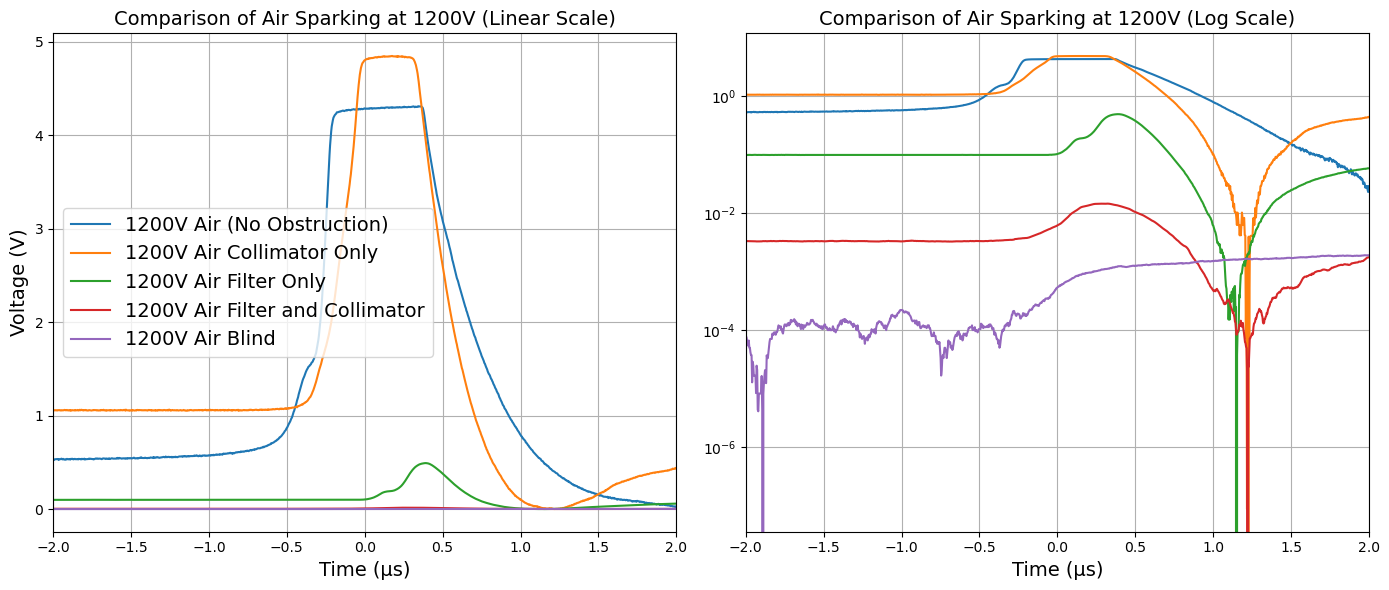

In [34]:
# File paths for uploaded CSV files
file_paths = [
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_air_noFilter_noIris_lastday (averaged waveform).csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_Air_Iris_Lastday (averaged waveform).csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirFilternoIrisLastday run 2 (averaged waveform).csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirFilterandIrisLastday (averaged waveform).csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirBlindLastday (averaged waveform).csv"
    # "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/55V_1200V_air_blind.csv"
]

# # Function to clean and prepare data
# def clean_waveform_data(file_path):
#     data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])
#     data["Time (s)"] = pd.to_numeric(data["Time (s)"], errors="coerce") * 1e6
#     data["SiPM Signal (V)"] = pd.to_numeric(data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce")
    
    
#     # Apply np.nan_to_num to replace NaNs with 0
#     data["SiPM Signal (V)"] = np.nan_to_num(data["SiPM Signal (V)"], copy=False, nan=0)
#     # # Baseline correction: subtract mean of first 500 points
#     # baseline = data["SiPM Signal (V)"][:500].mean()
#     # data["SiPM Signal (V)"] = data["SiPM Signal (V)"] - baseline


#     return data

def clean_waveform_data(file_path, zero=True, plot=False):
    data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])

    # Convert 'Time' and 'SiPM Signal' to numeric, handle NaNs
    data["Time (s)"] = pd.to_numeric(data["Time (s)"], errors="coerce") * 1e6
    data["SiPM Signal (V)"] = pd.to_numeric(
        data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce"
    )

    # Replace NaNs with 0
    data["SiPM Signal (V)"] = np.nan_to_num(data["SiPM Signal (V)"], nan=0.0)

    # Baseline correction using a larger window (e.g., first 2000 points)
    baseline_window = 2000
    baseline = data["SiPM Signal (V)"][:baseline_window].mean()
    data["SiPM Signal (V)"] -= baseline

    # Shift to non-negative values if zero=True
    if zero:
        min_value = np.min(data["SiPM Signal (V)"])
        if min_value < 0:
            data["SiPM Signal (V)"] -= min_value  # Shift only if necessary

    # Optional: Plot for verification
    if plot:
        plt.plot(data["Time (s)"], data["SiPM Signal (V)"], label="Baseline Corrected Signal")
        plt.title("Baseline Corrected and Zero Shifted SiPM Signal")
        plt.xlabel("Time [µs]")
        plt.ylabel("Amplitude [V]")
        plt.legend()
        plt.grid()
        plt.show()

    return data

# Prepare data for each file
data_list = [clean_waveform_data(path) for path in file_paths]



# # Function to plot all waveforms together
# def plot_superimposed_waveforms(data_list, x_column, y_column, labels, title="Comparison of Air Sparking at 1200V under different conditions (Log Scale)", xlabel="Time (µs)", ylabel="Voltage (V)"):
#     plt.figure(figsize=(12, 8))
#     for data, label in zip(data_list, labels):
#         plt.plot(data[x_column], data[y_column], label=label)
#     plt.title(title)
#     # plt.xlim(0, 0.0000025)
#     # -0.0000025
#     # plt.ylim(0.01, 5)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     # plt.yscale("log")
#     plt.xlim(-2, 5)
#     plt.legend()
#     plt.grid()
#     plt.show()



# Function to plot linear and log scale waveforms side by side
def plot_waveforms_side_by_side(data_list, x_column, y_column, labels, title_linear, title_log, xlabel="Time (µs)", ylabel="Voltage (V)"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
    
    # Linear scale plot
    for data, label in zip(data_list, labels):
        ax1.plot(data[x_column], data[y_column], label=label)
    ax1.set_title(title_linear, fontsize=14)
    ax1.set_xlabel(xlabel, fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    ax1.set_xlim(-2, 2)
    ax1.legend(fontsize=14)
    ax1.grid()

    # Log scale plot
    for data, label in zip(data_list, labels):
        ax2.plot(data[x_column], data[y_column], label=label)
    ax2.set_title(title_log, fontsize=14)
    ax2.set_xlabel(xlabel, fontsize=14)
    ax2.set_yscale("log")
    ax2.set_xlim(-2, 2)
    ax2.grid()
    
    plt.tight_layout()
    plt.show()



# Labels for the waveforms
labels = [
    "1200V Air (No Obstruction)",
    "1200V Air Collimator Only", 
    "1200V Air Filter Only",
    "1200V Air Filter and Collimator",
    "1200V Air Blind",
    ]

# # Plot the superimposed waveforms
# plot_superimposed_waveforms(data_list, "Time (s)", "SiPM Signal (V)", labels)


# Titles for the plots
title_linear = "Comparison of Air Sparking at 1200V (Linear Scale)"
title_log = "Comparison of Air Sparking at 1200V (Log Scale)"

# Plot linear and log scale waveforms side by side
plot_waveforms_side_by_side(data_list, "Time (s)", "SiPM Signal (V)", labels, title_linear, title_log)

# 3. Air (Collimator and Filter) for different voltages (we have two sets of data for this)

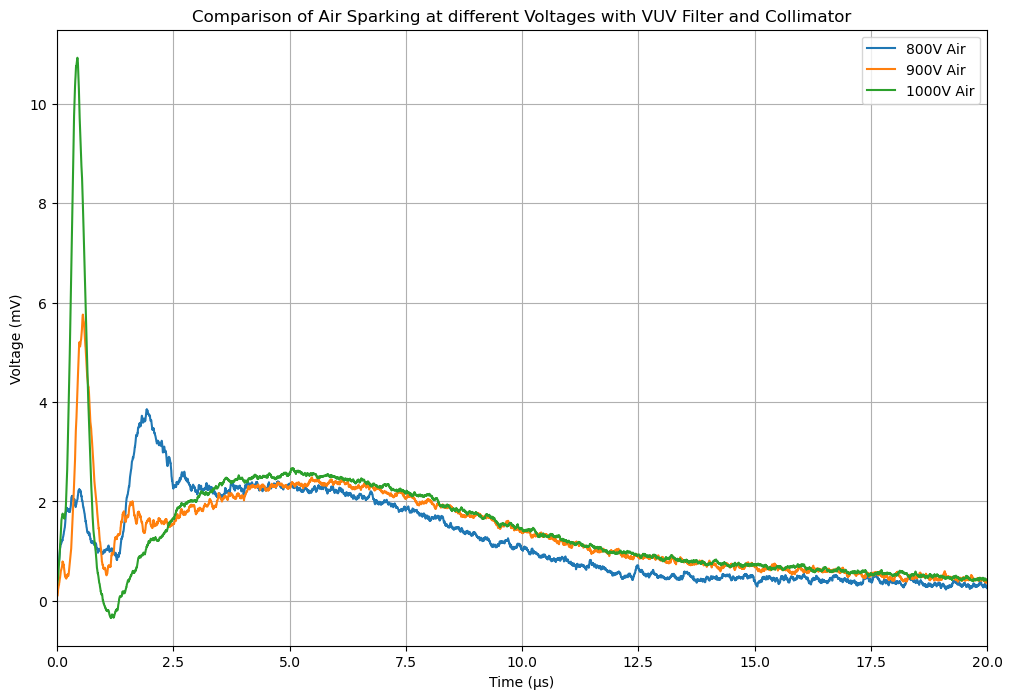

In [12]:
# File paths for uploaded CSV files
file_paths = [
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/800V_AirFilterandIrisLastday (averaged waveform).csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/900V_AirFilterandIrisLastday (averaged waveform).csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1000V_AirFilterandIrisLastday (averaged waveform).csv",
    # "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1100V_AirFilterandIrisLastday (averaged waveform).csv",
    # "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirFilterandIrisLastday (averaged waveform).csv"
]

# Function to clean and prepare data
def clean_waveform_data(file_path):
    data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])
    data["Time (s)"] = pd.to_numeric(data["Time (s)"], errors="coerce") * 1e6
    data["SiPM Signal (V)"] = pd.to_numeric(data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce") * 1e3

    # Baseline correction: subtract mean of first 500 points
    baseline = data["SiPM Signal (V)"][:500].mean()
    data["SiPM Signal (V)"] = data["SiPM Signal (V)"] - baseline
    return data

# Prepare data for each file
data_list = [clean_waveform_data(path) for path in file_paths]

# Function to plot all waveforms together
def plot_superimposed_waveforms(data_list, x_column, y_column, labels, title="Comparison of Air Sparking at different Voltages with VUV Filter and Collimator", xlabel="Time (µs)", ylabel="Voltage (mV)"):
    plt.figure(figsize=(12, 8))
    for data, label in zip(data_list, labels):
        plt.plot(data[x_column], data[y_column], label=label)
    plt.title(title)
    # plt.xlim(0, 0.0000025)
    # -0.0000025
    # plt.ylim(0.01, 5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.yscale("log")
    plt.xlim(0, 20)
    plt.legend()
    plt.grid()
    plt.show()

# Labels for the waveforms
labels = [
    "800V Air",
    "900V Air",
    "1000V Air",
    # "1100V Air",
    # "1200V Air"
    ]

# Plot the superimposed waveforms
plot_superimposed_waveforms(data_list, "Time (s)", "SiPM Signal (V)", labels)

# 4. Argon vacuum VS argon no vacuum

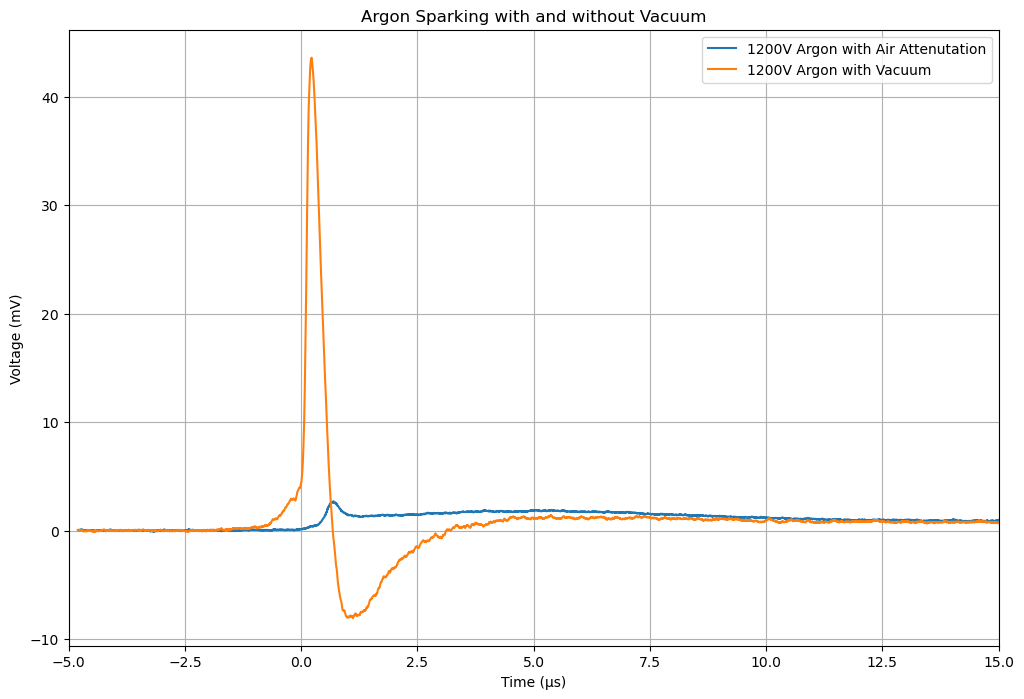

In [13]:
# File paths for uploaded CSV files
file_paths = [
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_ArgonFilterandIriswithAttenuationofAirinOpticallineandattenuation line (averaged waveform).csv",
    "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_ArgonFIlterandIrisLastday (averaged waveform).csv"
]

# Function to clean and prepare data
def clean_waveform_data(file_path):
    data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])
    data["Time (s)"] = pd.to_numeric(data["Time (s)"], errors="coerce") * 1e6
    data["SiPM Signal (V)"] = pd.to_numeric(data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce") * 1e3

    # Baseline correction: subtract mean of first 500 points
    baseline = data["SiPM Signal (V)"][:500].mean()
    data["SiPM Signal (V)"] = data["SiPM Signal (V)"] - baseline
    return data

# Prepare data for each file
data_list = [clean_waveform_data(path) for path in file_paths]

# Function to plot all waveforms together
def plot_superimposed_waveforms(data_list, x_column, y_column, labels, title="Argon Sparking with and without Vacuum", xlabel="Time (µs)", ylabel="Voltage (mV)"):
    plt.figure(figsize=(12, 8))
    for data, label in zip(data_list, labels):
        plt.plot(data[x_column], data[y_column], label=label)
    plt.title(title)
    # plt.xlim(0, 0.0000025)
    # -0.0000025
    # plt.ylim(0.01, 5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.yscale("log")
    plt.xlim(-5, 15)
    plt.legend()
    plt.grid()
    plt.show()

# Labels for the waveforms
labels = [
    "1200V Argon with Air Attenutation",
    "1200V Argon with Vacuum"
    ]

# Plot the superimposed waveforms
plot_superimposed_waveforms(data_list, "Time (s)", "SiPM Signal (V)", labels)

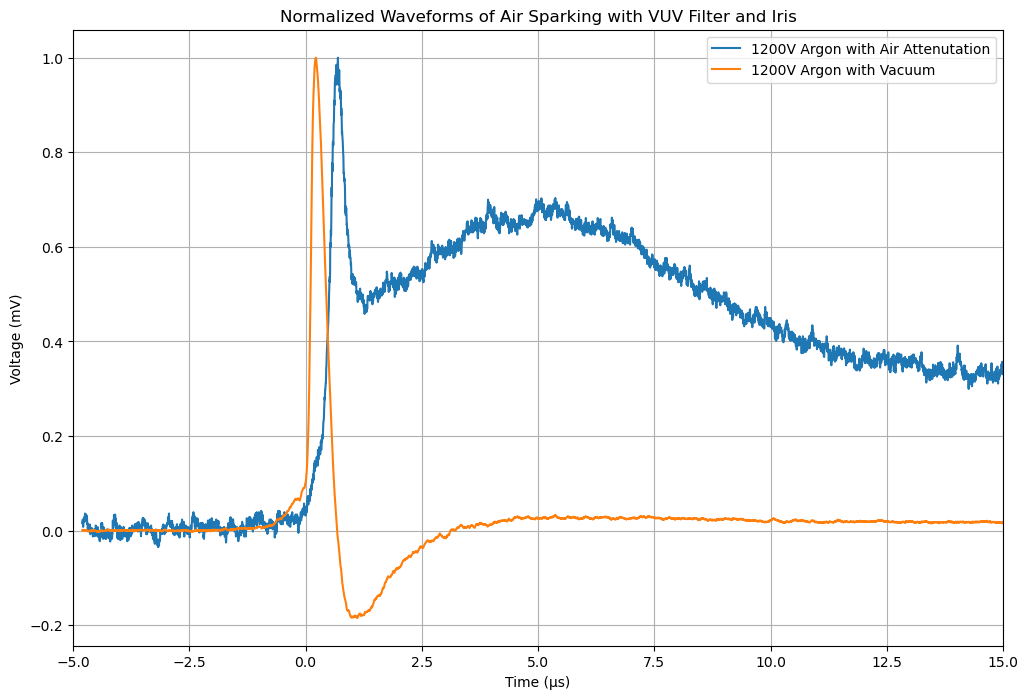

Scaling Factors (relative to the highest peak):
1200V Argon with Air Attenutation: 16.16 times
1200V Argon with Vacuum: 1.00 times


In [14]:
# Function to normalize the waveforms
def normalize_waveform(data, y_column):
    max_peak = data[y_column].max()
    data[y_column] = data[y_column] / max_peak  # Normalize by the maximum peak
    return max_peak

# List to store maximum peaks for scaling information
max_peaks = []

# Normalize each waveform and collect max peaks
for data in data_list:
    max_peaks.append(normalize_waveform(data, "SiPM Signal (V)"))

# Plot normalized waveforms
plot_superimposed_waveforms(
    data_list,
    "Time (s)",
    "SiPM Signal (V)",
    labels,
    title="Normalized Waveforms of Air Sparking with VUV Filter and Iris"
)

# Print the scaling factors
print("Scaling Factors (relative to the highest peak):")
for label, max_peak in zip(labels, max_peaks):
    print(f"{label}: {max(max_peaks) / max_peak:.2f} times")


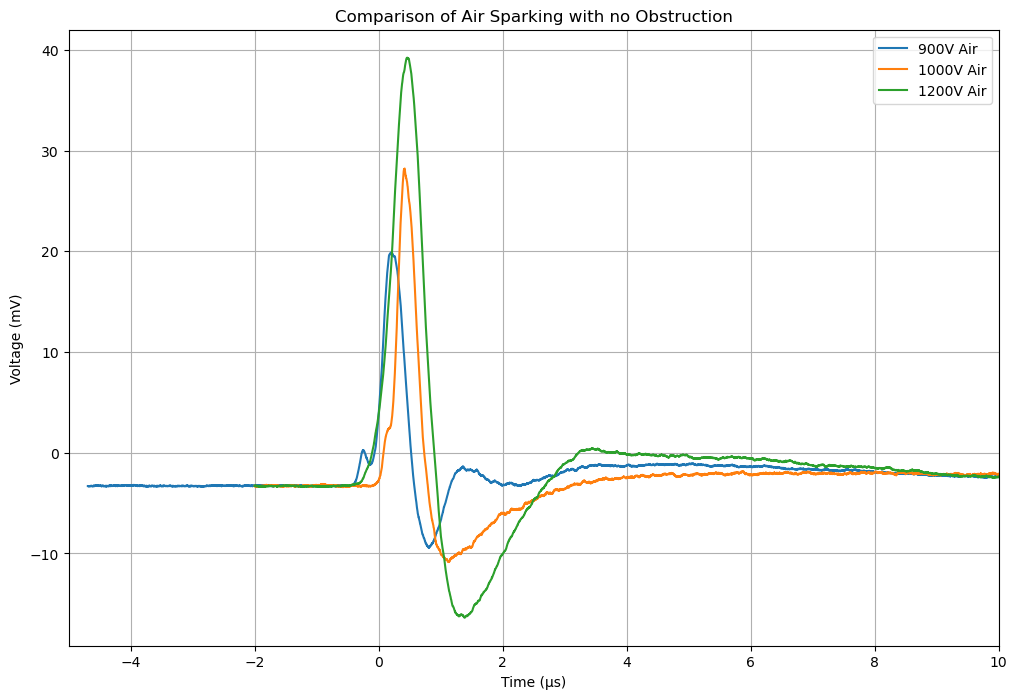

In [15]:
# File paths for uploaded CSV files
file_paths = [
    'C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/900V_air_VUVlastday (averaged waveform).csv',
    'C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1000V_air_VUVlastday (averaged waveform).csv',
    'C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_air_VUVlastday run 2 (averaged waveform).csv'
]

# Function to clean and prepare data
def clean_waveform_data(file_path):
    data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])
    data["Time (s)"] = pd.to_numeric(data["Time (s)"], errors="coerce") * 1e6
    data["SiPM Signal (V)"] = pd.to_numeric(data["SiPM Signal (V)"].astype(str).str.replace("+", "", regex=False), errors="coerce") * 1e3

    # # Baseline correction: subtract mean of first 500 points
    # baseline = data["SiPM Signal (V)"][:500].mean()
    # data["SiPM Signal (V)"] = data["SiPM Signal (V)"] - baseline
    return data

# Prepare data for each file
data_list = [clean_waveform_data(path) for path in file_paths]

# Function to plot all waveforms together
def plot_superimposed_waveforms(data_list, x_column, y_column, labels, title="Comparison of Air Sparking with no Obstruction", xlabel="Time (µs)", ylabel="Voltage (mV)"):
    plt.figure(figsize=(12, 8))
    for data, label in zip(data_list, labels):
        plt.plot(data[x_column], data[y_column], label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(-5, 10)
    plt.legend()
    plt.grid()
    plt.show()

# Labels for the waveforms
labels = [
    "900V Air",
    "1000V Air",
    "1200V Air"
]

# Plot the superimposed waveforms
plot_superimposed_waveforms(data_list, "Time (s)", "SiPM Signal (V)", labels)

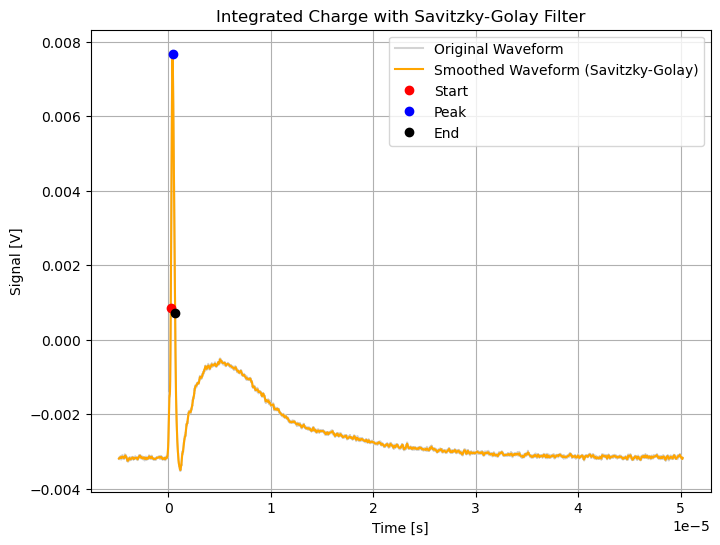

Integrated Charge: 2.03e-09 Vs


In [16]:
def integrate_single_waveform(file_path, start_offset=50, window_length=51, polyorder=3, plot=False, title="Integrated Charge"):
    """
    Load waveform data, clean it using Savitzky-Golay filter, dynamically determine start, peak, and end points,
    and compute the integrated charge.

    Args:
        file_path (str): Path to the waveform CSV file.
        start_offset (int): Number of points before the peak to define the start.
        window_length (int): Length of the filter window for Savitzky-Golay (odd number).
        polyorder (int): Polynomial order for Savitzky-Golay filter.
        plot (bool): Whether to plot the waveform and integration region.
        title (str): Title for the plot.

    Returns:
        float: Integrated charge (area under the curve).
    """
    # Load data
    data = pd.read_csv(file_path, skiprows=2, names=["Time (s)", "Trigger Signal (V)", "SiPM Signal (V)"])
    x_data = pd.to_numeric(data["Time (s)"], errors="coerce").values
    y_data = pd.to_numeric(data["SiPM Signal (V)"], errors="coerce").values

    # Remove invalid (NaN) values
    valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
    x_data_clean = x_data[valid_indices]
    y_data_clean = y_data[valid_indices]

    # Smooth the signal using Savitzky-Golay filter
    y_data_smooth = savgol_filter(y_data_clean, window_length=window_length, polyorder=polyorder)

    # Dynamically determine peak, start, and end indices
    peak_index = np.argmax(y_data_smooth)  # Peak is where the signal is maximum
    start_index = max(0, peak_index - start_offset)  # Start 50 points before the peak
    end_index = np.argmin(np.abs(y_data_smooth[peak_index:] - y_data_smooth[peak_index] / 10)) + peak_index

    # Integrate the signal using the trapezoidal rule
    integration_range = slice(start_index, end_index + 1)
    area = np.trapz(y_data_smooth[integration_range], x_data_clean[integration_range])

    # Plot the waveform and integration region if requested
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(x_data_clean, y_data_clean, label="Original Waveform", color="lightgray")
        plt.plot(x_data_clean, y_data_smooth, label="Smoothed Waveform (Savitzky-Golay)", color="orange")
        plt.plot(x_data_clean[start_index], y_data_smooth[start_index], 'ro', label="Start")
        plt.plot(x_data_clean[peak_index], y_data_smooth[peak_index], 'bo', label="Peak")
        plt.plot(x_data_clean[end_index], y_data_smooth[end_index], 'ko', label="End")
        plt.title(title)
        plt.xlabel("Time [s]")
        plt.ylabel("Signal [V]")
        plt.legend()
        plt.grid()
        plt.show()

    return area

# Example Usage:
file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1000V_AirFilterandIrisLastday (averaged waveform).csv"
area = integrate_single_waveform(file_path, start_offset=50, window_length=51, polyorder=3, plot=True, title="Integrated Charge with Savitzky-Golay Filter")
print(f"Integrated Charge: {area:.2e} Vs")


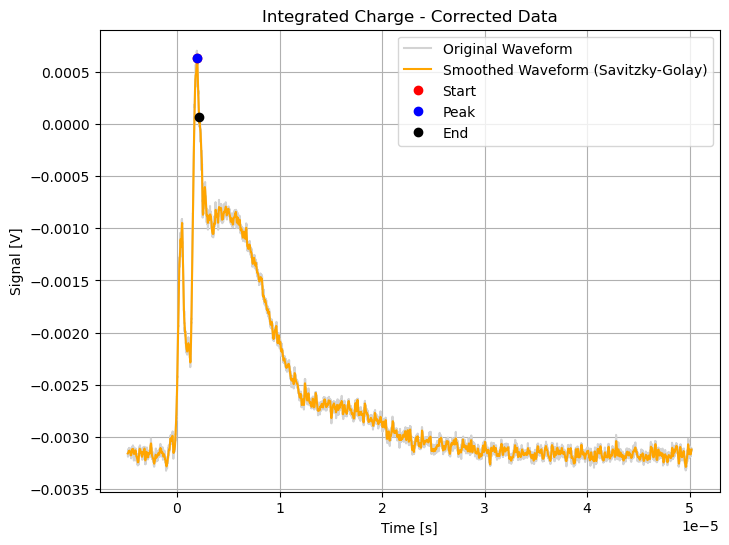

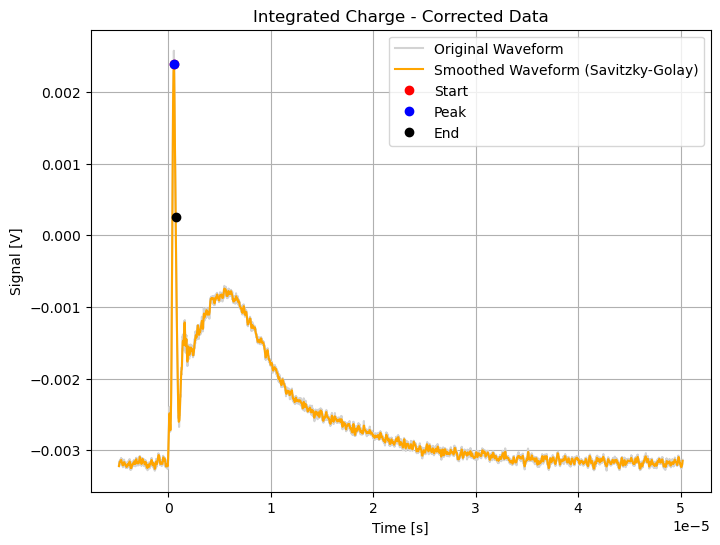

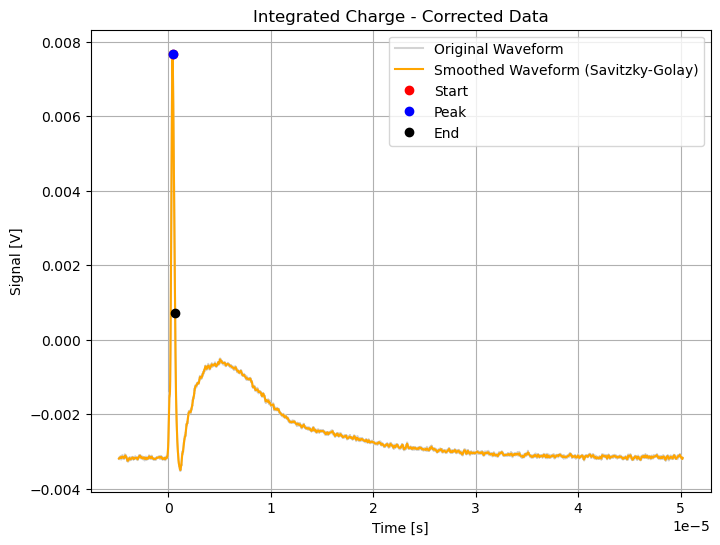

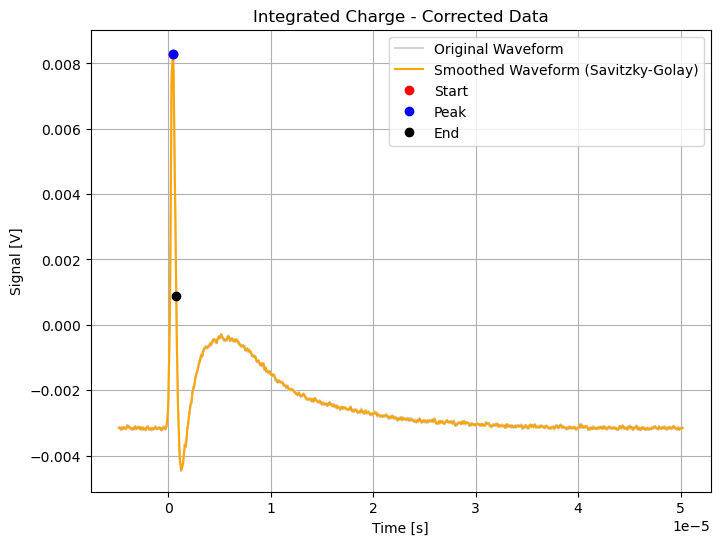

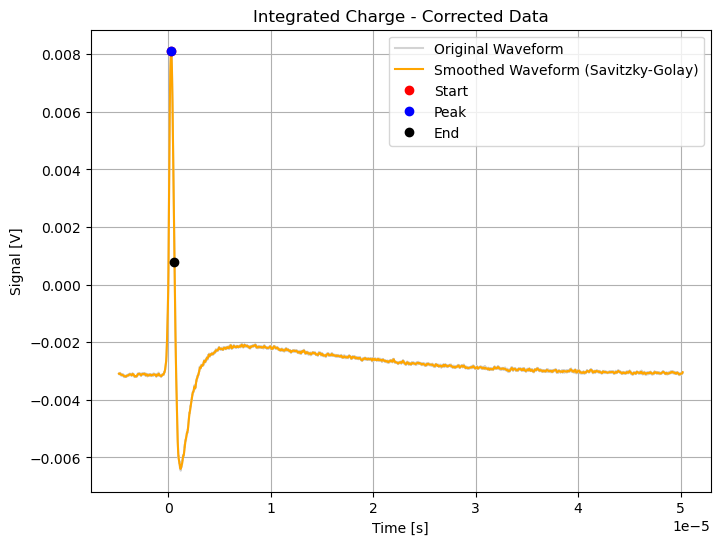

In [17]:
file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/800V_AirFilterandIrisLastday (averaged waveform).csv"
mean_800V_air = integrate_single_waveform(file_path, start_offset=0, plot=True, title="Integrated Charge - Corrected Data")

file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/900V_AirFilterandIrisLastday (averaged waveform).csv"
mean_900V_air = integrate_single_waveform(file_path, start_offset=0, plot=True, title="Integrated Charge - Corrected Data")

file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1000V_AirFilterandIrisLastday (averaged waveform).csv"
mean_1000V_air = integrate_single_waveform(file_path, start_offset=0, plot=True, title="Integrated Charge - Corrected Data")

file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1100V_AirFilterandIrisLastday (averaged waveform).csv"
mean_1100V_air = integrate_single_waveform(file_path, start_offset=0, plot=True, title="Integrated Charge - Corrected Data")

file_path = "C:/Users/kento/Documents/University of Manchester/University Work/Fourth Year/MPhys/MPhys Sem 1 SiPM_Scintillation(KeySight Oscilloscope)/1200V_AirFilterandIrisLastday (averaged waveform).csv"
mean_1200V_air = integrate_single_waveform(file_path, start_offset=0, plot=True, title="Integrated Charge - Corrected Data")

# Air with nothing VS Air with blind

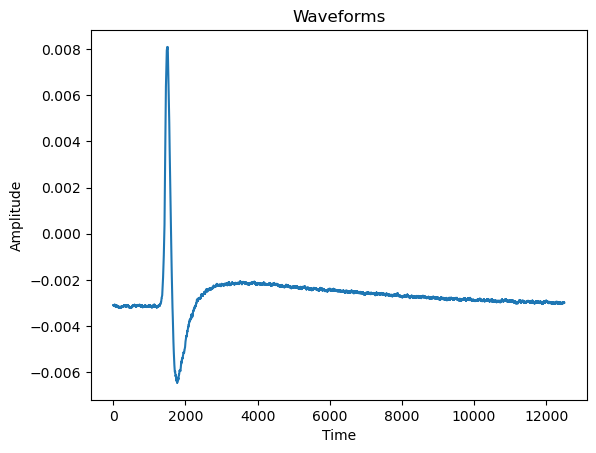

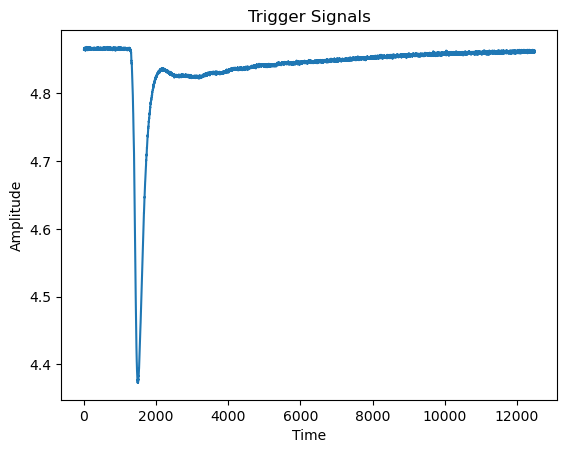

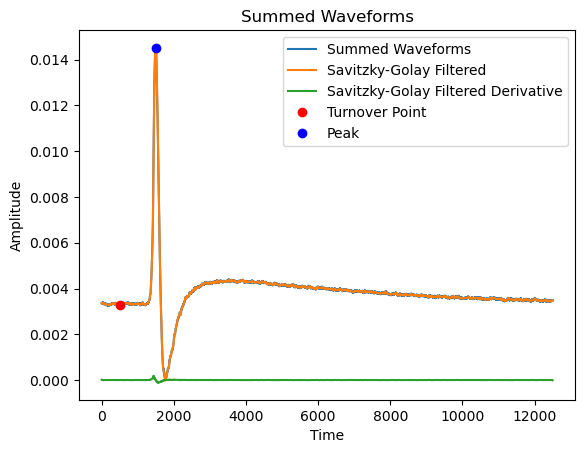

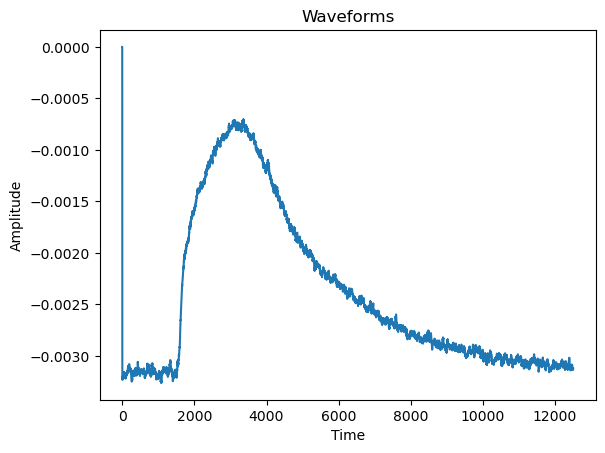

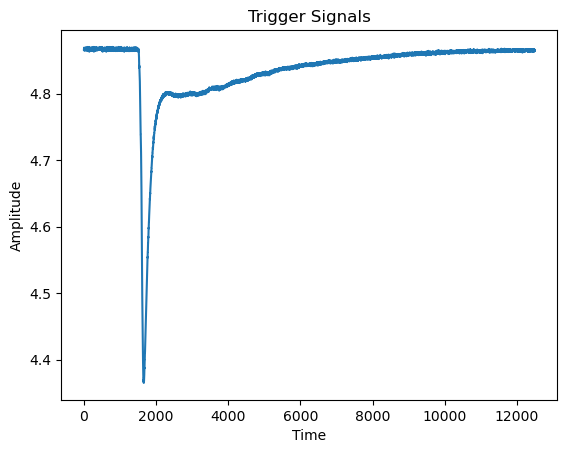

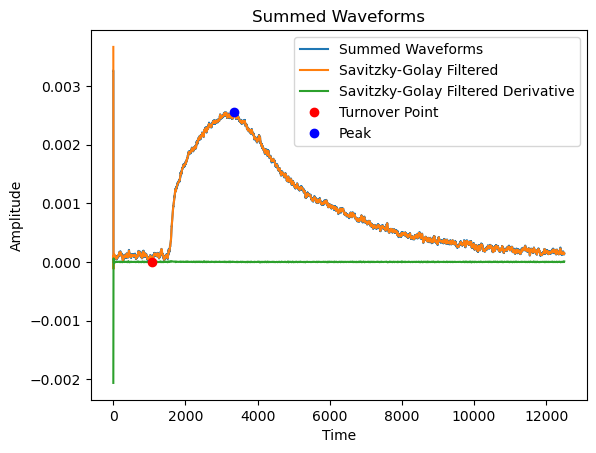

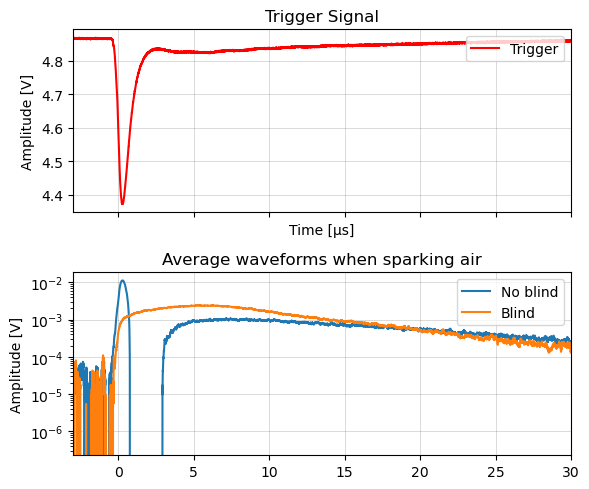

In [23]:
# waveforms_1200V_air, n_segs_1200V_air = read_data("55V_1200V_air.csv", 3571, zero=False)
# _, _, avg_1200V_air, avg_trig_1200V_air = find_roi(waveforms_1200V_air, n_segs_1200V_air, peak_start=500, turnover_start=500, turnover_end=800)

# waveforms_1200V_air_blind, n_segs_1200V_air_blind = read_data("55V_1200V_air_blind.csv", 12500, zero=False)
# _, _, avg_1200V_air_blind, _ = find_roi(waveforms_1200V_air_blind, n_segs_1200V_air_blind, peak_start=500, turnover_start=500, turnover_end=800)




waveforms_1200V_air, n_segs_1200V_air = read_data("1200V_AirFilterandIrisLastday (averaged waveform).csv", 12500, zero=False)
_, _, avg_1200V_air, avg_trig_1200V_air = find_roi(waveforms_1200V_air, n_segs_1200V_air, peak_start=500, turnover_start=500, turnover_end=800)

# waveforms_1200V_air, n_segs_1200V_air = read_data("1200V_air_noFilter_noIris_lastday (averaged waveform).csv", 12500, zero=False)
# _, _, avg_1200V_air, avg_trig_1200V_air = find_roi(waveforms_1200V_air, n_segs_1200V_air, peak_start=500, turnover_start=500, turnover_end=800)

waveforms_1200V_air_blind, n_segs_1200V_air_blind = read_data("1200V_AirBlindLastday (averaged waveform).csv", 12500, zero=False)
_, _, avg_1200V_air_blind, _ = find_roi(waveforms_1200V_air_blind, n_segs_1200V_air_blind, peak_start=1000, turnover_start=1000, turnover_end=10000)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(waveforms_1200V_air[0, :, 0] * 1e6, avg_trig_1200V_air, color='red', label="Trigger")
ax1.set_xlim(-3, 30)
ax1.set_title("Trigger Signal")
ax1.set_xlabel("Time [µs]")
ax1.set_ylabel("Amplitude [V]")
ax1.legend(loc="upper right")
ax1.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.2)



ax2.plot(waveforms_1200V_air[0, :, 0] * 1e6, avg_1200V_air, label="No blind")
ax2.plot(waveforms_1200V_air_blind[0, :, 0] * 1e6, avg_1200V_air_blind, label="Blind")
ax2.set_yscale("log")
ax2.set_xlim(-3, 30)
ax2.set_title("Average waveforms when sparking air")
ax2.set_ylabel("Amplitude [V]")
ax2.legend(loc="upper right")
ax2.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.2)

plt.tight_layout()

plt.show()

CVGBHJKL:s

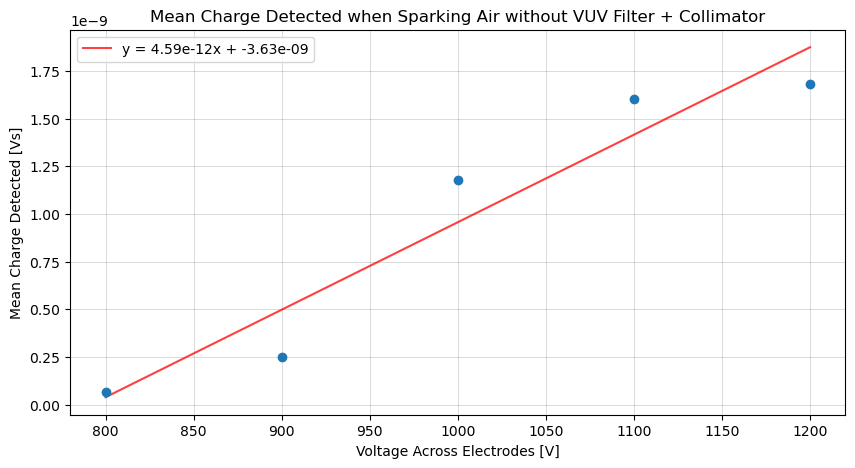

In [19]:
# Data points
voltages = np.array([800, 900, 1000, 1100, 1200])
means = np.array([mean_800V_air, mean_900V_air, mean_1000V_air, mean_1100V_air, mean_1200V_air])
# std_devs = np.array([std_1000V_air, std_1100V_air, std_1200V_air])

# Fit a line to the data
coefficients = np.polyfit(voltages, means, 1)  # Linear fit (degree 1)
slope, intercept = coefficients

# Generate x values for the line of best fit
x_fit = np.linspace(min(voltages), max(voltages), 100)
y_fit = slope * x_fit + intercept

# Plot the data with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(voltages, means, fmt='o', capsize=5)
plt.plot(x_fit, y_fit, label=f"y = {slope:.2e}x + {intercept:.2e}", color='red', alpha=0.75)

# Add labels, title, and grid
plt.title("Mean Charge Detected when Sparking Air without VUV Filter + Collimator")
plt.xlabel("Voltage Across Electrodes [V]")
plt.ylabel("Mean Charge Detected [Vs]")
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.2)

# Show the plot
plt.show()